In [1]:
import collections
import glob
import itertools
import re
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def popular(iterable, limit):
    """
    A little utility to compute popular values on an iterable.
    """
    return collections.Counter(iterable).most_common(limit)

In [3]:
def article_text_to_dict(article_text: str):
    """
    Translates an article text into a dict.
    """
    data = collections.defaultdict(list)
    field = ''
    for line in re.split(r'\n+', article_text):
        # Fix little bug with isi files
        if line.startswith('null'):
            line = line[4:]
        name = line[:2]
        value = line[3:]
        if not name.isspace():
            field = name
        if not field.isspace() and field != 'ER':
            data[field].append(value)
    return dict(data)

In [4]:
class WosToolsError(Exception):
    """
    All the errors go here.
    """
    pass


class Article(object):
    """
    Abstract a WOS article.
    """

    def __init__(self, article_text):
        self._article_text = article_text
        self._data = article_text_to_dict(article_text)

    def __getattr__(self, name):
        if name not in self._data and not hasattr(self._data, name):
            raise AttributeError('{self.__class__.__name__} does not have an attribute %s' %name)
        if name not in self._data:
            return getattr(self._data, name)
        return self._data[name]

    def __hasattr__(self, name):
        return name in self._data


class CollectionLazy(object):
    """
    A collection of WOS text files.
    """

    def __init__(self, *filenames):
        self.filenames = filenames

    @classmethod
    def from_glob(cls, pattern):
        """
        Creates a new collection from a pattern using glob.
        """
        return cls(*glob.glob(pattern))

    @property
    def files(self):
        """
        Iterates over all files in the collection
        """
        for filename in self.filenames:
            try:
                with open(filename) as filehandle:
                    yield filehandle
            except FileNotFoundError:
                raise WosToolsError('The file %s was not found' %filename)

    @property
    def article_texts(self):
        """
        Iterates over all the single article texts in the colection.
        """
        for filehandle in self.files:
            data = filehandle.read()
            for article_text in data.split('\n\n')[1:]:
                if article_text == 'EF':
                    continue
                yield article_text

    @property
    def articles(self):
        """
        Iterates over all articles.
        """
        for article_text in self.article_texts:
            yield Article(article_text)

    @property
    def authors(self):
        """
        Iterates over all article authors, including duplicates
        """
        authors = (
            article.AF
            for article in self.articles
            if hasattr(article, 'AF')
        )
        return itertools.chain(*authors)

    @property
    def coauthors(self):
        """
        Iterates over coauthor pairs.
        """
        authors_by_article = (
            article.AF
            for article in self.articles
            if hasattr(article, 'AF')
        )
        return itertools.chain(*(
            itertools.combinations(sorted(authors), 2)
            for authors in authors_by_article
        ))

    def completeness(self, key=None):
        """
        Computes the completeness of the collection by key.
        """
        counters = collections.defaultdict(int)
        total = 0
        for article in self.articles:
            total += 1
            for key in article.keys():
                counters[key] += 1
        return {key: val/total for key, val in counters.items()}

# Building the graph

In [5]:
a = CollectionLazy.from_glob('*.txt')
authors_list = set(list(a.authors))
coauthors_list = list(a.coauthors)

In [6]:
G = nx.Graph()
G.add_nodes_from(authors_list)

for aut in authors_list:
    G.node[aut]['weight'] = len(G[aut])
    
for i,co in enumerate(coauthors_list):
    G.add_edge(*co, weight = coauthors_list.count(coauthors_list[i]))
    
print('Number of Nodes: ',G.number_of_nodes())
print('Number of Edges: ',G.number_of_edges())

Number of Nodes:  2414
Number of Edges:  8856


(-1.1325740597040677,
 1.1341816909093447,
 -1.1050143950982851,
 1.1170350345434632)

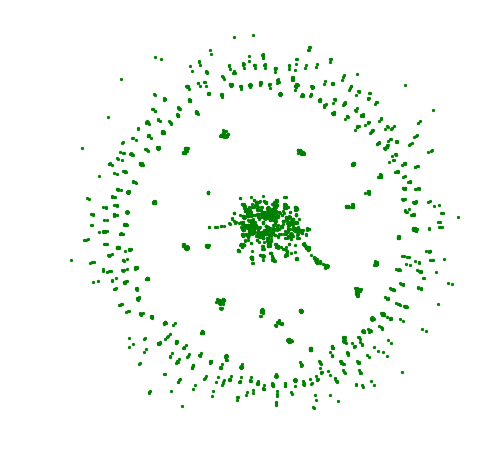

In [7]:
elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >10]
esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=10]
pos = nx.spring_layout(G)
plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(G,pos,node_size=5, node_color='g')
nx.draw_networkx_edges(G,pos,edgelist=elarge, width=3, edge_color='k')
nx.draw_networkx_edges(G,pos,edgelist=esmall, width=3,alpha=0.5,edge_color='w',style='dashed')
plt.axis('off')
plt.axis('equal')

In [8]:
print(G['Hasegawa, Takashi'])
print(G['Hasegawa, Takashi']['Ishio, Shunji'])

{'Yamane, Haruki': {'weight': 1}, 'Nagamachi, Shinji': {'weight': 1}, 'Kondo, Yuji': {'weight': 2}, 'Arakawa, Akira': {'weight': 1}, 'Homma, Takayuki': {'weight': 1}, 'Ishio, Shunji': {'weight': 3}, 'Wodarz, Siggi': {'weight': 1}, 'Uebayashi, Kazuhiko': {'weight': 1}}
{'weight': 3}
